In [85]:
import os
import itertools
import pandas as pd
import numpy as np
from module import Data_Agument
from datasets import Dataset
from datasets import load_metric
import torch
from sklearn.model_selection import train_test_split
import pickle
from livelossplot import PlotLosses
import sklearn
import torch.nn as nn
from module import report
from module import pytorchtools
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
label_list = [
'<pad>',
'O',
'B-RightSpeaker',   
'B-Speaker',
'B-LeftSpeaker',
'B-Unknown',
'I-RightSpeaker',
'I-Speaker',
'I-LeftSpeaker',
'I-Unknown'
]
label_encoding_dict = {
'<pad>':0,
'O': 1,
'B-RightSpeaker': 2,   
'B-Speaker': 3,
'B-LeftSpeaker': 4,
'B-Unknown': 5,
'I-RightSpeaker': 6,
'I-Speaker': 7,
'I-LeftSpeaker': 8,
'I-Unknown': 9,
}

def get_all_tokens_and_ner_tags(directory):
    return pd.concat([get_tokens_and_ner_tags(directory) ]).reset_index().drop('index', axis=1)
    
def get_tokens_and_ner_tags(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        split_list = [list(y) for x, y in itertools.groupby(lines, lambda z: z == '\n') if not x]
        tokens = [[x.split(' ')[0] for x in y] for y in split_list]
        entities = [[x.split(' ')[1][:-1] for x in y] for y in split_list] 
    return pd.DataFrame({'tokens': tokens, 'ner_tags': entities})

def get_un_token_dataset(directory,Rondom):
    if Rondom==True:
        df , AFTER_NAME_LIST_APPEAR_1 , AFTER_NAME_LIST__OVER_1 = Data_Agument.get_Data_Agument(directory)
        print(len(AFTER_NAME_LIST_APPEAR_1) , len(AFTER_NAME_LIST__OVER_1))
    else:
        df = get_all_tokens_and_ner_tags(directory)
    for i in range(len(df)):
        df.ner_tags[i]=[ "O" if d =="Out" else d for d in df.ner_tags[i]]

    df_train, df_test = train_test_split(df, test_size=0.3)
    df_test, df_val = train_test_split(df_test, test_size=0.5)
    #df_train, df_test = train_test_split(df)
    test_dataset = Dataset.from_pandas(df_test.reset_index(drop=True))
    train_dataset = Dataset.from_pandas(df_train.reset_index(drop=True))
    val_dataset = Dataset.from_pandas(df_val.reset_index(drop=True))

    return (df,train_dataset,test_dataset,val_dataset)

cuda:0


In [86]:
hi_para={
    "EMBEDDING_DIM":512,
    "HIDDEN_DIM":512,
    "dropout":{"drop":0.4,"drop2":0.4},
    "BACH_SIZE":128,
    "epochs":300,
    "lr":0.0001,
    "weight_decay":0.00001,
    "num_layer":3,
    "patience":20
}

In [87]:
# 単語のベクトル次元数
EMBEDDING_DIM = hi_para["EMBEDDING_DIM"]
# 隠れ層の次元数
HIDDEN_DIM = hi_para["HIDDEN_DIM"]
#ドロップアウト率
dropout2 = hi_para["dropout"]["drop2"]
dropout = hi_para["dropout"]["drop"]
#バッチサイズ
BACH_SIZE = hi_para["BACH_SIZE"]
# ループ回
epochs = hi_para["epochs"]
#学習率
lr = hi_para["lr"]
weight_decay = hi_para["weight_decay"]
num_layer = hi_para["num_layer"]
patience = hi_para["patience"]

In [88]:
path_checkpoint = 'path/model_LSTM_path.pth'
#path_model = "model_lstm/Lstm.pth"

In [89]:
df,train_dataset,test_dataset,val_dataset= get_un_token_dataset("./DirectQuote/data/truecased.txt",True)

877 1783


In [90]:
import pickle
with open('dict/word2id.pkl', 'rb') as f:
    word2id = pickle.load(f) 
with open('dict/id2word.pkl', 'rb') as f:
     id2word = pickle.load(f)
word2id["<pad>"]=0
id2word[0]="<pad>"

In [91]:
import torch

def wordid(word,word2id):
    return[word2id.get(token.lower())for token in word ]


def tagid(word,tagid):
    return[label_encoding_dict.get(token)for token in word ]


class MyDataset(torch.utils.data.Dataset):
    def __init__(self,df,word2id,label_encoding_dict):
        self.features_values =df["tokens"]
        self.labels = df["ner_tags"]
        self.word2id = word2id
        self.label_encoding_dict=label_encoding_dict


    def __len__(self):
        return len(self.features_values)


    def __getitem__(self, idx):
        
        labels = torch.LongTensor(tagid(list(self.labels)[idx],label_encoding_dict))
        features = torch.LongTensor(wordid(list(self.features_values)[idx],word2id))
        return features, labels
    
    
Train_Dataset = MyDataset(train_dataset,word2id,label_encoding_dict)
Test_Dataset = MyDataset(test_dataset,word2id,label_encoding_dict)
Val_Dataset = MyDataset(val_dataset,word2id,label_encoding_dict)

In [92]:
def collate_batch(batch):
    label_list, text_list, = [], []
    for (_text,_label) in batch:
        label_list.append(_label)
        text_list.append(_text)
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value= 0)
    label_list = torch.nn.utils.rnn.pad_sequence(label_list, batch_first=True, padding_value=0)
    return text_list,label_list



from torch.utils.data import DataLoader

Train_dataloader = DataLoader(
    dataset=Train_Dataset,
    batch_size=BACH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)
Val_dataloader = DataLoader(
    dataset= Val_Dataset,
    batch_size=BACH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)
Tes_dataloader = DataLoader(
    dataset= Test_Dataset,
    batch_size=BACH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)

In [93]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.1, reduction='mean',ignore_index=0):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction,ignore_index=self.ignore_index)


In [94]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class LSTM(nn.Module):
    def __init__(self, nb_layers, nb_lstm_units, embedding_dim, batch_size,dropout,dropout2):
        super(LSTM, self).__init__()
        self.vocab = word2id
        self.tags = label_encoding_dict
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = dropout2
        self.nb_lstm_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.nb_tags = len(self.tags) 
        self.__build_model()
        self.lstm


    def __build_model(self):
        nb_vocab_words = len(self.vocab)
        padding_idx = self.vocab['<pad>']
        self.word_embedding = nn.Embedding(
            num_embeddings=nb_vocab_words,
            embedding_dim=self.embedding_dim,
            padding_idx=padding_idx
        )

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_lstm_layers,
            batch_first=True,
            dropout= self.drop2 if self.nb_lstm_layers > 1else 0,
        )
        self.hidden_to_tag = nn.Linear(self.nb_lstm_units, self.nb_tags)
    def forward(self, X):
        batch_size, seq_len = X.size()
        X = self.word_embedding(X)
        X = self.drop1(X)
        # now run through LSTM
        X,_ = self.lstm(X)
        X = X.contiguous()
        X = X.view(-1, X.shape[2])
        X = self.hidden_to_tag(X)
        X = F.log_softmax(X, dim=1)
        X = X.view(batch_size, seq_len, self.nb_tags)
        Y_hat = X
        return Y_hat

In [95]:
import torch.optim as optim
model = LSTM(num_layer, HIDDEN_DIM, EMBEDDING_DIM, BACH_SIZE,dropout,dropout2)
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
loss_function = LabelSmoothingCrossEntropy(ignore_index=0)

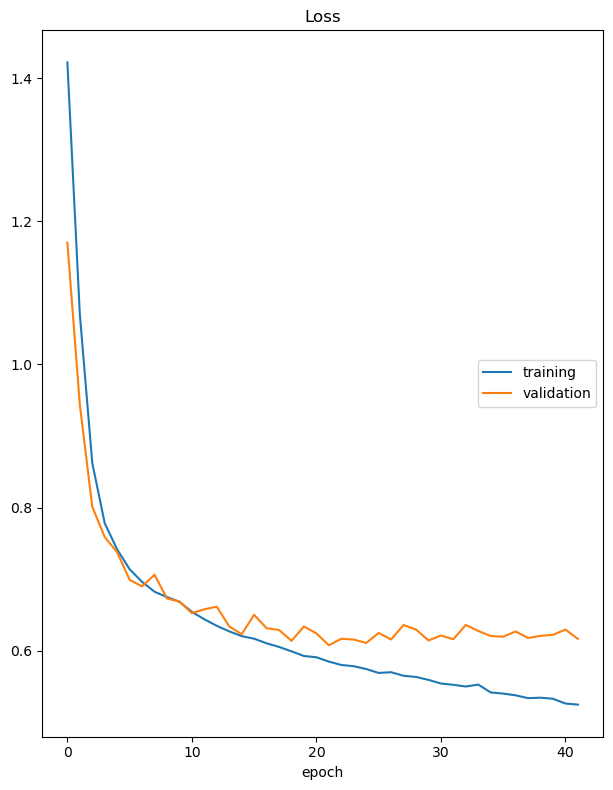

Loss
	training         	 (min:    0.525, max:    1.422, cur:    0.525)
	validation       	 (min:    0.608, max:    1.170, cur:    0.617)
EarlyStopping counter: 20 out of 20
Early Stopping
CPU times: user 5min 55s, sys: 17.6 s, total: 6min 13s
Wall time: 6min 16s


In [96]:
%%time
liveloss = PlotLosses()
early_stopping = pytorchtools.EarlyStopping(patience=patience, verbose=True,path=path_checkpoint)
for epoch in range(epochs):
    model.to(device)
    print("epoch", epoch)
    logs = {}
    model.train()
    train_loss = 0
    train_accuracy = 0
    for datas,labels in tqdm(Train_dataloader):
            t_bach_loss=0
            optimizer.zero_grad()
            data=datas.to(device)
            label=labels.to(device)
            out = model(data)
            _, predict = torch.max(out, 2)
            out=out.view(-1,len(label_list))
            label=label.view(-1)
            t_bach_loss = loss_function(out,label)
            train_loss += t_bach_loss.item()
            t_bach_loss.backward()
            optimizer.step()
    logs['loss'] = train_loss  / len(Train_dataloader)
    model.eval() 
    with torch.inference_mode():
        valu_loss = 0
        valu_accuracy = 0
        for datas, labels in tqdm(Val_dataloader):
            v_bach_loss = 0
            data = datas.to(device)
            label = labels.to(device)
            out = model(data)
            out=out.view(-1,len(label_list))
            label=label.view(-1)
            v_bach_loss = loss_function(out,label)
            valu_loss += (v_bach_loss.item())

        logs['val_loss'] = valu_loss  / len(Val_dataloader)
        
    liveloss.update(logs)
    liveloss.send()
    early_stopping(valu_loss/len(Val_dataloader),model)
    
    if early_stopping.early_stop:
        print("Early Stopping")
        model.load_state_dict(torch.load(path_checkpoint))
        break  

In [102]:
def Viterbi(scores_bert, num_entity_type, penalty=10000):
        m = num_entity_type 
        
        penalty_matrix = np.zeros([m, m])
        """
        for x in range(1,5):
            for y in range(1,9):
                if (x+4 == y):
                    penalty_matrix[y,x]=penalty
        """        
        for x in range(6,10):
            for y in range(0,10):
                if (x==y or x == 4+y):
                    penalty_matrix[y,x]=0
                else:
                    penalty_matrix[y,x]=1000
        path = [ [i] for i in range(m) ]
        scores_path = scores_bert[0] - penalty_matrix[0,:]
        scores_bert = scores_bert[1:]
        for scores in scores_bert:
            assert len(scores) == num_entity_type 
            score_matrix = np.array(scores_path).reshape(-1,1) \
                + np.array(scores).reshape(1,-1) \
                - penalty_matrix
            scores_path = score_matrix.max(axis=0)
            argmax = score_matrix.argmax(axis=0)
            path_new = []
            for i, idx in enumerate(argmax):
                path_new.append( path[idx] + [i] )
            path = path_new
        #print(score_matrix)
        labels_optimal = path[np.argmax(scores_path)]
        return labels_optimal

In [103]:
def DATA_CLEAN(out, mask):
    pre = [label_list[out[i + 1]] for i in range(sum(mask > 0) - 2)]
    return (report.get_entities(pre), pre)


def evaluate_model(batch_entities_list, batch_entities_predicted_list, type_id=None):
    num_entities = 0
    num_predictions = 0
    num_correct = 0 
    for entities_list, entities_predicted_list in zip(batch_entities_list, batch_entities_predicted_list):
        for entities, entities_predicted in zip(entities_list, entities_predicted_list):
            if type_id:
                entities = [e for e in entities if e[0] == type_id]
                entities_predicted = [
                    e for e in entities_predicted if e[0] == type_id
                ]

            get_span_type = lambda e: (e[1], e[2], e[0])
            set_entities = set(get_span_type(e) for e in entities)
            set_entities_predicted = set(get_span_type(e) for e in entities_predicted)
            num_entities += len(entities)
            num_predictions += len(entities_predicted)
            num_correct += len(set_entities & set_entities_predicted)

    precision = num_correct/num_predictions
    recall = num_correct/num_entities
    f_value = 2*precision*recall/(precision+recall)

    result = {
        'num_entities': num_entities,
        'num_predictions': num_predictions,
        'num_correct': num_correct,
        'precision': precision,
        'recall': recall,
        'f_value': f_value
    }

    return result


def eval_model(label, lists):
    eval_label_encoding_dict = {
        "Speaker": "Speaker",
        "Quoat": "Quoat"
    }
    eval_df = pd.DataFrame()
    for k, v in eval_label_encoding_dict.items():
        eval_res = evaluate_model(label, lists, type_id=v)
        eval_df[k] = eval_res.values()

    eval_res_all = evaluate_model(label, lists, type_id=None)
    eval_df["ALL"] = eval_res_all.values()

    eval_df.index = eval_res_all.keys()
    return eval_df


In [104]:
from torchcrf import CRF
CRF(len(label_list), batch_first=True)._viterbi_decode

<bound method CRF._viterbi_decode of CRF(num_tags=10)>

In [184]:
import copy
def mat3(datasets, MO):
    crf=CRF(len(label_list), batch_first=True)
    penalty_matrix = np.zeros([10, 10], dtype='float64')

    for x in range(6,10):
        for y in range(0,10):
            if (x==y or x == 4+y):
                penalty_matrix[y,x]=0
            else:
                penalty_matrix[y,x]=-0.1
    crf.transitions=nn.Parameter(torch.tensor(penalty_matrix))
    L2, P2 = [], []
    MO.eval
    MO.to(device)
    with torch.no_grad():
        for datas,labels in tqdm((datasets)):
            datas = datas.to(device)
            labels = labels.to(device)
            mask = copy.deepcopy(labels)
            mask[labels > 0] = 1
            output = MO(datas)
            _, predict = torch.max(output, 2)
            preT = crf.decode(output.to("cpu"), mask.bool().to("cpu"))
            out_list = map(DATA_CLEAN,
                                preT,
                                mask.cpu().numpy().copy())
            out_label = map(DATA_CLEAN,
                                 labels,
                                 mask.cpu().numpy().copy())
            #print([pd.DataFrame({'pre': p[1], 'true': l[1]}) for p, l in zip(list(out_list), list(out_label))])
            P2.append([o[0] for o in list(out_list)])
            L2.append([o[0] for o in list(out_label)])


    return L2, P2, eval_model(L2, P2)

In [185]:
L, P, eval_result= mat3(Tes_dataloader, model)

  0%|          | 0/23 [00:00<?, ?it/s]

In [145]:
eval_result

,Speaker,Quoat,ALL
num_entities,624.000000,700.000000,1324.000000
num_predictions,765.000000,613.000000,1378.000000
num_correct,460.000000,378.000000,838.000000
precision,0.601307,0.616639,0.608128
recall,0.737179,0.540000,0.632931
f_value,0.662347,0.575781,0.620281
